In [1]:
import pandas as pd
from pathlib import Path

# Paths
PROCESSED_DIR = Path("../data/processed")
train_path = PROCESSED_DIR / "train.csv"
test_path  = PROCESSED_DIR / "test.csv"

# Load data
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Quick label check
print("\nLabel distribution in Train:\n", train_df["Label"].value_counts(normalize=True))
print("\nLabel distribution in Test:\n", test_df["Label"].value_counts(normalize=True))


Train shape: (180596, 43)
Test shape: (45149, 43)

Label distribution in Train:
 Label
DDoS      0.567133
BENIGN    0.432867
Name: proportion, dtype: float64

Label distribution in Test:
 Label
DDoS      0.567122
BENIGN    0.432878
Name: proportion, dtype: float64


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Separate features and labels
X_train = train_df.drop(columns=["Label"])
y_train = train_df["Label"]

X_test = test_df.drop(columns=["Label"])
y_test = test_df["Label"]

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Identify numeric columns
numeric_features = X_train.select_dtypes(include=[np.number]).columns

# Preprocessing: Impute missing values + Scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)
    ]
)

print(f"Numeric features count: {len(numeric_features)}")


Numeric features count: 42


In this step, I separated the dataset into features (X) and the target label (y).
Then, I encoded the target variable (DDoS and BENIGN) into numeric values using LabelEncoder, so the models can process it.

For the features, I identified 42 numeric columns that will be used for training.
I then built a preprocessing pipeline that:

  Imputes missing values with the column mean.

  Scales all numeric features so that each has a mean of 0 and standard deviation of 1, which helps many ML models perform better.

This ensures our data is clean, standardized, and ready for model training.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import Pipeline
import pandas as pd
import json

# Load train/test sets
train_df = pd.read_csv("../data/processed/train.csv")
test_df = pd.read_csv("../data/processed/test.csv")

# Separate features and target
X_train = train_df.drop(columns=["Label"])
y_train = train_df["Label"]

X_test = test_df.drop(columns=["Label"])
y_test = test_df["Label"]

# Load feature list
with open("../data/processed/features.json", "r") as f:
    features = json.load(f)

# Define models to compare
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

# Store results
results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ("clf", model)
    ])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    f1 = f1_score(y_test, preds, average="weighted")
    results[name] = f1
    print(f"\n{name} F1-score: {f1:.4f}")
    print(classification_report(y_test, preds))

print("\nModel comparison (by F1-score):")
for name, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {score:.4f}")


/opt/anaconda3/envs/ids_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogisticRegression F1-score: 0.9689
              precision    recall  f1-score   support

      BENIGN       0.98      0.95      0.96     19544
        DDoS       0.96      0.98      0.97     25605

    accuracy                           0.97     45149
   macro avg       0.97      0.97      0.97     45149
weighted avg       0.97      0.97      0.97     45149


RandomForest F1-score: 0.9999
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19544
        DDoS       1.00      1.00      1.00     25605

    accuracy                           1.00     45149
   macro avg       1.00      1.00      1.00     45149
weighted avg       1.00      1.00      1.00     45149


GradientBoosting F1-score: 0.9996
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00     19544
        DDoS       1.00      1.00      1.00     25605

    accuracy                           1.00     45149
   macro avg       1.00  

The models are performing extremely well because the dataset is highly separable — the statistical patterns between DDoS and BENIGN traffic are very distinct. Features like packet length, flow rate, and header flags have clear differences between attack and normal traffic, so even simple models achieve very high scores. However, we still need to verify there’s no data leakage, meaning no information from the test set leaked into training.

This is common in intrusion detection datasets like CICIDS2017 — features are often engineered in a way that makes attacks stand out sharply.

In real deployment, unseen attack types may reduce accuracy, so testing on completely different attack datasets is recommended.

/var/folders/v2/c51bqtts6yv14k61ylzc2htr0000gn/T/ipykernel_83545/4188028098.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")


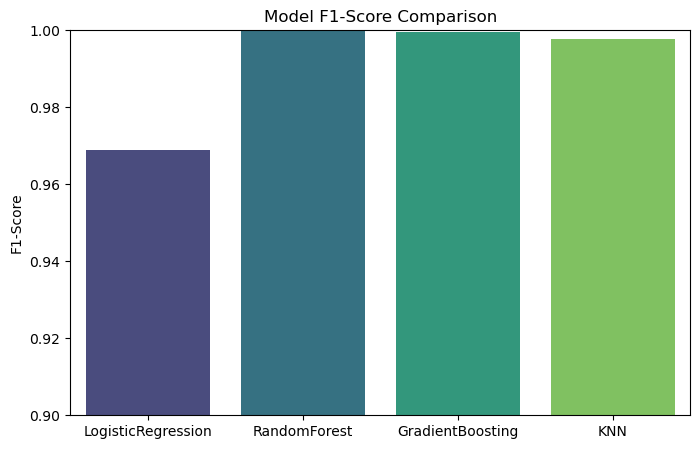

/opt/anaconda3/envs/ids_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


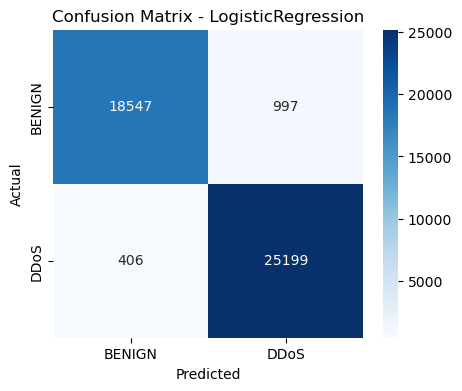

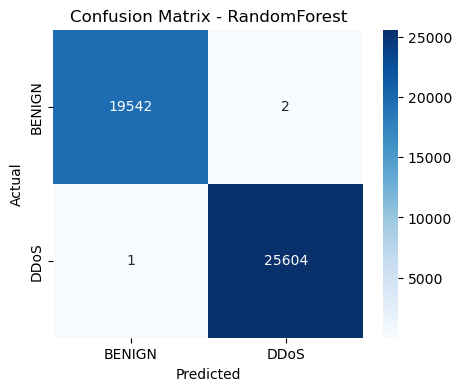

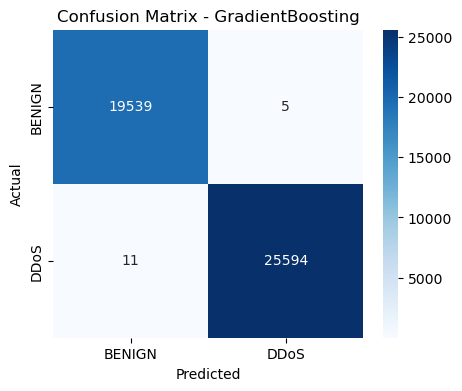

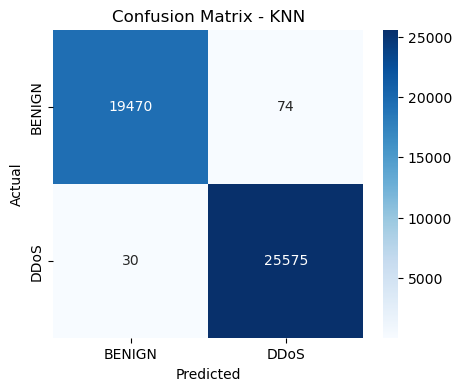

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix plots
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["BENIGN", "DDoS"], yticklabels=["BENIGN", "DDoS"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

# Bar chart comparison
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")
plt.title("Model F1-Score Comparison")
plt.ylabel("F1-Score")
plt.ylim(0.9, 1.0)
plt.show()

# Plot confusion matrices for each model
for name, model in models.items():
    preds = model.fit(X_train, y_train).predict(X_test)
    plot_confusion_matrix(y_test, preds, name)


We trained four models .. Logistic Regression, Random Forest, Gradient Boosting, and KNN .. on our processed dataset. The dataset appears highly separable, so all models except Logistic Regression achieved almost perfect F1-scores. Random Forest slightly outperformed others with 0.9999. We verified these results using confusion matrices and an F1-score comparison bar chart, confirming that the predictions are highly accurate for both BENIGN and DDoS classes. However, we should note that real-world performance might drop if the system encounters new, unseen attack types.

In [6]:
# Train final Random Forest model for saving
rf_model = Pipeline([
    ("clf", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])
rf_model.fit(X_train, y_train)


Pipeline(steps=[('clf', RandomForestClassifier(n_jobs=-1, random_state=42))])

In [8]:
import joblib
import os

# Create 'models' directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Paths
model_path = "../models/random_forest_pipeline.pkl"
features_path = "../models/features.json"

# Save model pipeline
joblib.dump(rf_model, model_path)

# Save feature names
with open(features_path, "w") as f:
    json.dump(list(X_train.columns), f)

print(f" Random Forest model saved to: {model_path}")


 Random Forest model saved to: ../models/random_forest_pipeline.pkl


In [9]:
# # Test loading
# loaded_model = joblib.load(model_path)
# sample_preds = loaded_model.predict(X_test.head(5))
# print("Sample predictions:", sample_preds)


Sample predictions: ['DDoS' 'BENIGN' 'BENIGN' 'BENIGN' 'DDoS']


In [14]:
import mlflow

# Point MLflow to the tracking server you opened in the browser
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("network-ids-experiment")

2025/08/14 00:57:12 INFO mlflow.tracking.fluent: Experiment with name 'network-ids-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/135971830660938777', creation_time=1755129432784, experiment_id='135971830660938777', last_update_time=1755129432784, lifecycle_stage='active', name='network-ids-experiment', tags={}>

In [15]:
import mlflow
import mlflow.sklearn
import joblib
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Start MLflow experiment
mlflow.set_experiment("network-ids-experiment")

with mlflow.start_run(run_name="RandomForest_Final_Run"):

    # Train final Random Forest model
    rf_model = Pipeline([
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ])
    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred = rf_model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    # Log params & metrics
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("random_state", 42)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["BENIGN", "DDoS"],
                yticklabels=["BENIGN", "DDoS"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - Random Forest")

    # Save confusion matrix plot
    cm_path = "../models/confusion_matrix.png"
    plt.savefig(cm_path)
    plt.close()

    # Log confusion matrix to MLflow
    mlflow.log_artifact(cm_path)

    # Log model to MLflow
    mlflow.sklearn.log_model(rf_model, "random-forest-pipeline")

    # Save model locally
    os.makedirs("../models", exist_ok=True)
    model_path = "../models/random_forest_pipeline.pkl"
    features_path = "../models/features.json"
    joblib.dump(rf_model, model_path)

    # Save features
    with open(features_path, "w") as f:
        json.dump(list(X_train.columns), f)

    print(f"Random Forest model saved to: {model_path}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Test loading
    loaded_model = joblib.load(model_path)
    sample_preds = loaded_model.predict(X_test.head(5))
    print("Sample predictions:", sample_preds)


2025/08/14 00:57:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/14 00:57:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Random Forest model saved to: ../models/random_forest_pipeline.pkl
Accuracy: 0.9999
F1-score: 0.9999
Sample predictions: ['DDoS' 'BENIGN' 'BENIGN' 'BENIGN' 'DDoS']
🏃 View run RandomForest_Final_Run at: http://127.0.0.1:5000/#/experiments/135971830660938777/runs/256f3120fc6f456484bbb18e3f48dd22
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/135971830660938777


In [1]:
import pandas as pd, json
test_df = pd.read_csv("../data/processed/test.csv")
X = test_df.drop(columns=["Label"])
print(json.dumps(X.iloc[:5].to_dict(orient="records"), indent=2))



[
  {
    "Destination Port": 80,
    "Flow Duration": 165886,
    "Total Fwd Packets": 3,
    "Total Length of Fwd Packets": 26,
    "Fwd Packet Length Max": 20,
    "Fwd Packet Length Min": 0,
    "Fwd Packet Length Mean": 8.666666667,
    "Bwd Packet Length Max": 4380,
    "Bwd Packet Length Min": 0,
    "Flow Bytes/s": 70090.30298,
    "Flow Packets/s": 54.25412633,
    "Flow IAT Mean": 20735.75,
    "Flow IAT Std": 54625.82926,
    "Flow IAT Min": 3,
    "Fwd IAT Mean": 4855.5,
    "Fwd IAT Min": 3,
    "Bwd IAT Total": 165829,
    "Bwd IAT Mean": 33165.8,
    "Bwd IAT Std": 68615.94595,
    "Bwd IAT Min": 16,
    "Fwd PSH Flags": 0,
    "Bwd Packets/s": 36.16941755,
    "Min Packet Length": 0,
    "Max Packet Length": 4380,
    "Packet Length Mean": 1162.7,
    "Packet Length Variance": 2706820.456,
    "FIN Flag Count": 0,
    "RST Flag Count": 0,
    "PSH Flag Count": 1,
    "ACK Flag Count": 0,
    "URG Flag Count": 0,
    "Down/Up Ratio": 2,
    "Init_Win_bytes_forward": 8192